# Interpretação de modelos usando SHAP

SHAP (SHapley Additive exPlanations) é o nome de um **método** baseado na teoria dos jogos que pode ser aplicado a qualquer modelo preditivo. Tem como objetivo possibilitar a explicação de uma predição feita pelo modelo. 

Um exemplo de como o método SHAP funciona: imagine um modelo de regressão que usa três **variáveis** (A, B, C) como entrada. Digamos que o **valor médio** da variável resposta seja de +2.5, e que o modelo prevê o valor de +4.0 para uma certa amostra. O método SHAP fornece uma **interpretação** desse tipo: 
- partimos do valor médio de +2.5
- a variável A contribui com +1.5 (nomenclatura: dizemos que o **valor SHAP** — ou valor de Shapley calculado pelo módulo shap — da variável A é +1.5 para essa amostra)
- a variável B com +2.0
- a variável C com -2.0
- somando as contribuições: 2.5 + 1.5 + 2.0 - 2.0 = 4.0

Dessa forma, supondo que estamos lidando com um modelo de regressão em que valores maiores são melhores, poderíamos dizer algo como: "o valor da variável C para essa amostra contribui negativamente com o valor da predição, e poderia ser otimizado".

Esse foi um exemplo de **interpretação local** (para uma amostra específica). O SHAP também oferece **interpretações globais**, fazendo a média dos valores SHAP locais para todas as amostras.

O módulo em Python que implementa o método SHAP é chamado `shap`. Neste Notebook, são mostrados alguns exemplos de uso do módulo `shap` adaptados da página do projeto no GitHub e de diversas fontes *online*.

Fontes usadas:

**SHAP**
- https://christophm.github.io/interpretable-ml-book/shap.html
- https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454
- https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

**Plots**
- https://github.com/slundberg/shap
- https://shap-lrjball.readthedocs.io/en/latest/example_notebooks/kernel_explainer/Census%20income%20classification%20with%20scikit-learn.html
- https://analyticsindiamag.com/a-complete-guide-to-shap-shapley-additive-explanations-for-practitioners/
- https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

**Interações**
- https://github.com/conorosully/medium-articles/blob/master/src/shap_interaction.ipynb
- https://towardsdatascience.com/finding-and-visualising-interactions-14d54a69da7c?jr=on
- https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a?jr=on

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost
from sklearn.model_selection import train_test_split

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
# O aviso acima será corrigido na versão 1.6 do xgboost
xgboost.__version__

'1.5.1'

In [3]:
# isso é necessário para mostrar os plots no Jupyter e no Google Colab
shap.initjs() 

In [4]:
# O módulo shap disponibiliza alguns conjuntos de dados para treinamento de modelos
help(shap.datasets)

Help on module shap.datasets in shap:

NAME
    shap.datasets

FUNCTIONS
    a1a()
        A sparse dataset in scipy csr matrix format.
    
    adult(display=False)
        Return the Adult census data in a nice package.
    
    boston(display=False)
        Return the boston housing data in a nice package.
    
    cache(url, file_name=None)
        Loads a file from the URL and caches it locally.
    
    california(display=False, n_points=None)
        Return the california housing data in a nice package.
    
    communitiesandcrime(display=False)
        Predict total number of non-violent crimes per 100K popuation.
        
        This dataset is from the classic UCI Machine Learning repository:
        https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalized
    
    corrgroups60(display=False)
        Correlated Groups 60
        
        A simulated dataset with tight correlations among distinct groups of features.
    
    diabetes(display=False)
        

# 1. Explicando um modelo de regressão

Vamos usar o conjunto de dados "California housing data", para prever preços de casas.

Para mais informações sobre esse conjunto de dados: https://github.com/ageron/handson-ml/tree/master/datasets/housing

In [5]:
# Importar conjunto de dados
X, y = shap.datasets.california()

In [6]:
X.shape

(20640, 8)

In [7]:
# Verificar se todos os valores são válidos
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [8]:
# Separar um conjunto para treinamento e um para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=0)

In [9]:
# Vou selecionar só 500 amostras, para os cálculos ficarem mais rápidos
# X = X[0:500]
# y = y[0:500]

**Importante**: É possível usar o `shap` para amostras no conjunto de treinamento ou de teste. Em geral, é melhor usar um conjunto de treinamento para treinar o modelo, validar com um conjunto externo e, somente se for possível observar boa generalização, interpretar as predições feitas pelo modelo.

In [10]:
# Treinar modelo de regressão usando XGBoost
model = xgboost.XGBRegressor().fit(X_train, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [11]:
# Predições feitas pelo modelo
y_pred = model.predict(X_test)

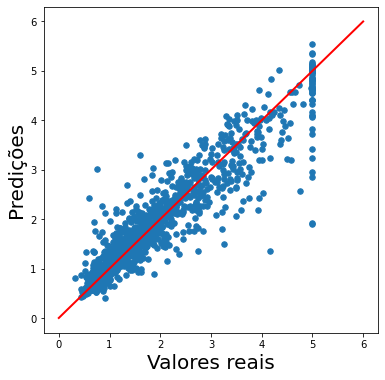

In [12]:
# Gráfico das predições
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))

plt.scatter(y_test, y_pred, s=30)
plt.plot([0, 6], [0, 6], color='r', linestyle='-', linewidth=2)

plt.xlabel('Valores reais',size=20)
plt.ylabel('Predições',size=20)

plt.show()

## 1.1. Explainer

Para explicar as predições feitas pelo nosso modelo, precisamos criar um objeto do tipo `Explainer` usando o módulo `shap`:

In [13]:
# Criando um objeto "Explainer"
explainer = shap.Explainer(model)

In [14]:
type(explainer)

shap.explainers._tree.Tree

Comentário: O objeto é do tipo `shap.explainers._tree.Tree`. O `shap` é otimizado para trabalhar com modelos baseados em árvores (Random Forest, LightGBM, CatBoost, XGBoost).

Podemos usar esse objeto para gerar os valores de Shapley para os nossos dados e, em seguida, visualizar diferentes tipos de gráficos para interpretação.

In [15]:
# Os valores de Shapley são calculados usando os dados de teste (X_test) como input do objeto Explainer
# Se quiser interpretar predições para os valores de treinamento, pode usar o conjunto de dados completo (X)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [16]:
shap_values.shape

(1032, 8)

Agora, cada entrada do conjunto de teste (X_test) teve seu valor predito pelo modelo, e as explicações para essas predições estão disponíveis na variável `shap_values`.

A variável `shap_values` é uma matriz: cada linha corresponde a uma predição, e contém uma coluna para cada variável usada no modelo.

## 1.2. Predições individuais

Por definição, os valores de Shapley são calculados individualmente, para cada amostra.

Como exemplo, vamos visualizar as explicações da primeira predição (em Python, índice 0) usando os plots a seguir.

### Force plot

Pense em cada variável como uma "força" que "empurra" o valor da predição no sentido positivo ou negativo, partindo do valor médio. Quanto mais importante a variável, maior o "empurrão".

In [17]:
# Visualizar a explicação da primeira predição com um force plot
shap.plots.force(shap_values[0])

Vemos aqui como funciona o método SHAP: toda predição parte do *valor médio de todas as predições* e, a esse valor médio, *acrescentamos* as contribuições de cada descritor (que podem ser positivas ou negativas), de forma que o valor final (média + valores SHAP) seja igual ao valor da predição.

Para essa predição, vemos que o maior impacto é da variável `Longitude`, e é um impacto negativo (azul, desloca o valor da predição para a esquerda).

### Waterfall plot

Contém as mesmas informações do *force plot*, mas é possível visualizar os valores de Shapley individualmente.

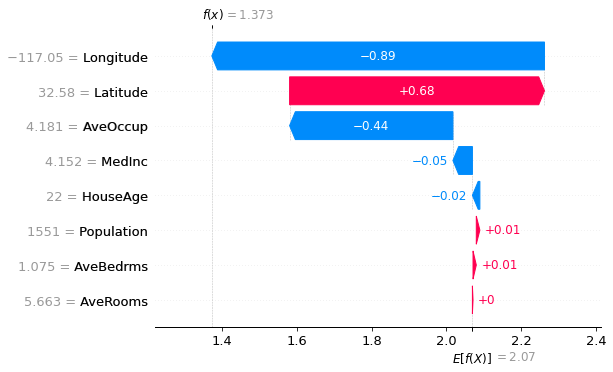

In [18]:
# visualizar as explicações da primeira predição (índice 0)
shap.plots.waterfall(shap_values[0])

### Decision plot

Contém a mesma informação que os plots anteriores. O *decision plot* é mais interessante para comparar várias predições (veja a próxima seção).

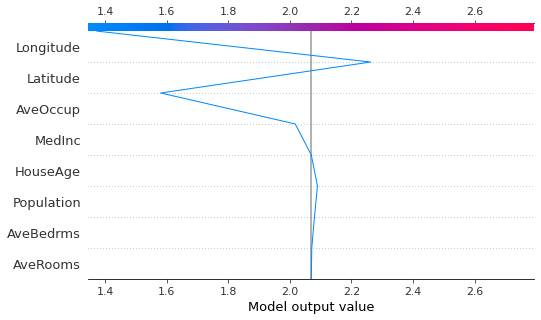

In [19]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[0], X_test.columns)

## 1.3. Predições globais

Os valores de Shapley de cada predição podem ser combinados de forma a gerar explicações globais (médias) para os modelos.

### Force plot global

Imagine que os *force plots* de todas as amostras foram calculados, rotacionados em 90° e agrupados horizontalmente, de forma que amostras com valores SHAP mais parecidos entre si fiquem próximas umas das outras. O gráfico é interativo, sendo possível descobrir a qual amostra um *force plot* pertence apenas clicando sobre ele. Aqui, mostramos somente as 100 primeiras amostras do conjunto de teste.

Nota: Acho esse plot bem confuso, e fica pior quanto mais amostras acrescentamos.

In [20]:
shap.force_plot(explainer.expected_value, shap_values.values[0:100], X_test)

### Mean SHAP plots (Bar plots)

Esse plot mostra a média dos valores SHAP (em valores absolutos) para cada descritor, considerando todas as amostras preditas. Barras maiores indicam descritores que costumam apresentar valores SHAP maiores (positivos ou negativos) em diferentes amostras, portanto, com maior impacto global.

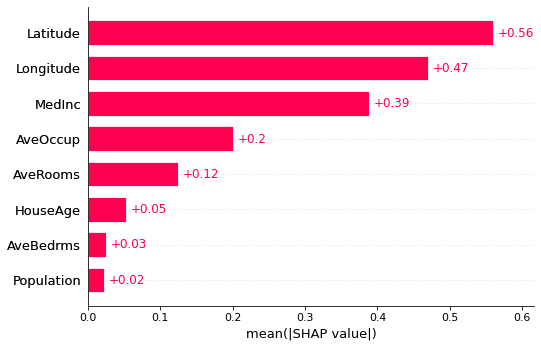

In [21]:
shap.plots.bar(shap_values)

Compare com a importância de variáveis calculada pelo `XGBoost`, que usa como parâmetro de importância o número de vezes que uma variável aparece em uma árvore de decisão (*weight*).

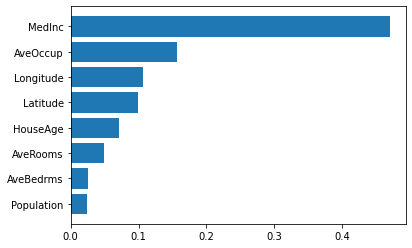

In [22]:
# importância de variáveis calculada pelo XGBoost - weights
df_bar = pd.DataFrame()
df_bar["Features"] = model.get_booster().feature_names
df_bar["XGBoost Importance"] = model.feature_importances_
df_bar = df_bar.sort_values('XGBoost Importance')
plt.barh(df_bar["Features"], df_bar["XGBoost Importance"])
plt.show()

### Decision plot

Agrega os valores SHAP de várias amostras em um único gráfico. Cada linha representa uma amostra, e o desvio horizontal corresponde ao valor SHAP de cada variável, representadas no eixo y. Aqui estou mostrando as 10 primeiras predições. Mostrar muitas predições pode tornar o gráfico muito poluído.

O site do `shap` tem uma [documentação](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html) detalhada sobre os *decision plots*, vale a pena conferir se quiser se aprofundar mais.

Nota: Acho esse plot um pouco confuso, e fica pior quanto mais amostras acrescentamos. Ele serve para dar uma ideia de como os valores SHAP de cada variável mudam de acordo com as amostras, e também é possível observar *outliers* (amostras cujos valores SHAP variam de forma muito distinta das outras).

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


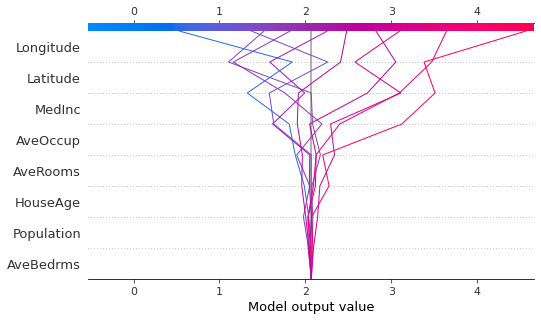

In [23]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[0:10], X_test.columns)

### Summary plot global (Beeswarm)

Para obter uma visão geral de quais variáveis são mais importantes para um modelo, podemos plotar os valores SHAP **de cada variável para cada amostra**. 

O gráfico abaixo organiza as variáveis de acordo com a soma das magnitudes dos valores SHAP para todas as amostras (variáveis mais importantes globalmente ficam mais para cima), e usa os valores SHAP para mostrar a distribuição dos impactos que cada variável tem na saída do modelo. A cor dos pontos representa o valor da variável correspondente (rosa = alto, azul = baixo). Pontos que se sobrepõem são deslocados verticalmente para melhor compreensão do gráfico.

Esse plot apresenta algumas vantagens com relação aos anteriores: 
- permite a visualização de todas as amostras sem ficar poluído como o *force plot* e o *decision plot*
- contém a mesma informação dos *bar plots*, já que as variáveis globais mais importantes ficam mais para cima

Por isso, vale a pena tentar entender o que ele representa. Há duas formas de mostrar o mesmo gráfico:

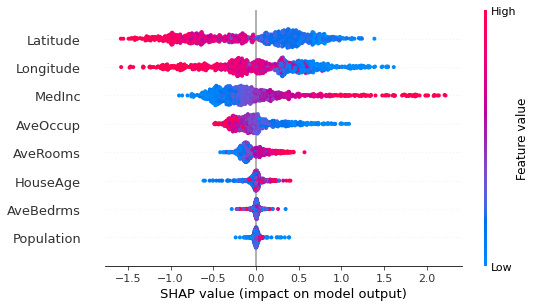

In [24]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

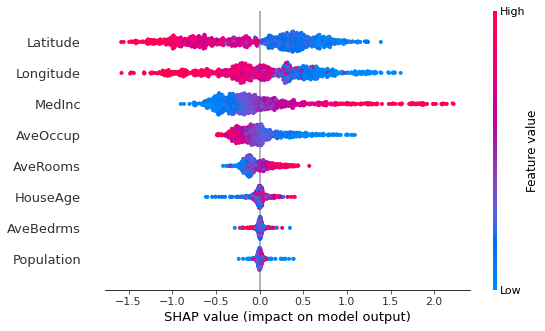

In [25]:
# Summary plot 
shap.summary_plot(shap_values, X_test)

Podemos ver, por exemplo, que `Latitude` é a variável global mais importante, com maior impacto absoluto médio (é a primeira variável no eixo y). Além disso, vemos, por exemplo, que um valor alto de `MedInc` (pontos rosas na terceira linha) tende a aumentar o preço previsto para uma casa (no eixo x, correspondem a valores SHAP positivos).

## 1.4. Interações

Os valores SHAP são usados para explicar predições individuais feitas por um modelo, mostrando as contribuições de cada variável para a predição final. Os valores de interação SHAP estendem essa ideia, dividindo as contribuições em **efeitos principais** e **efeitos de interação**, no caso, interação com outras variáveis. 

Para entender interações, responda a seguinte pergunta: uma pessoa mais velha deve receber um salário maior ou menor que uma mais nova? A resposta é: depende. Em um banco, por exemplo, os cargos Sênior devem receber mais que os Júnior. Mas e se estivermos falando de um jogador de futebol? Nesse caso, jogadores mais velhos, em fim de carreira, recebem menos que os mais novos. Portanto, podemos dizer que a variável "Idade" interage com a variável "Profissão", já que o impacto da variável "Idade" na resposta "Salário" depende da natureza da "Profissão".

In [26]:
# Cálculo das interações
shap_interaction = explainer.shap_interaction_values(X_test)

### Matriz de contribuição individual

Observar uma matriz de contribuição individual permite a explicação de previsões individuais.

Os efeitos principais aparecem nas diagonais, e os efeitos de interação, nas diagonais (as interações são divididas por 2 pois aparecem duas vezes na tabela: a interação da variável A com a B é o mesmo da B com a A).

In [27]:
# SHAP interaction values para a primeira predição
pd.DataFrame(shap_interaction[0], index=X_test.columns, columns=X_test.columns)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,-0.002624,-0.002842,0.032297,-0.001532,0.004714,-0.066403,-0.055766,0.040043
HouseAge,-0.002842,0.012929,0.004131,0.001345,-0.003516,-0.002295,-0.022129,-0.007567
AveRooms,0.032297,0.004131,-0.020372,-0.007712,0.000281,-0.017065,0.025749,-0.015647
AveBedrms,-0.001532,0.001345,-0.007712,0.013886,0.008229,-0.017361,0.000273,0.011627
Population,0.004714,-0.003516,0.000281,0.008229,0.007054,-0.011397,0.008064,-0.003850
AveOccup,-0.066403,-0.002295,-0.017065,-0.017361,-0.011397,-0.328750,-0.070143,0.076667
Latitude,-0.055766,-0.022129,0.025750,0.000273,0.008064,-0.070143,1.094229,-0.298785
Longitude,0.040042,-0.007567,-0.015647,0.011627,-0.003850,0.076667,-0.298785,-0.691885


In [28]:
# Valor médio das predições
mean_pred = np.mean(y_pred)

# Soma dos interaction values para a primeira predição
sum_shap = np.sum(shap_interaction[0])

print("Predição (primeira amostra, índice 0):                        {:.3f}".format(y_pred[0]))
print("Valor médio de todas as predições:                            {:.3f}".format(mean_pred))
print("Soma dos valores principais + interações (primeira amostra): {:.3f}".format(sum_shap))
print("Valor médio das predições + soma:                             {:.3f}".format(mean_pred + sum_shap))

Predição (primeira amostra, índice 0):                        1.373
Valor médio de todas as predições:                            2.046
Soma dos valores principais + interações (primeira amostra): -0.697
Valor médio das predições + soma:                             1.349


Entendendo o que é mostrado acima: cada valor SHAP de uma variável pode ser "desmembrado" em "valor principal" e "valores de interação". Somando o valor principal a todas as interações, obtemos o valor SHAP para uma variável. Juntando os valores SHAP de todas as variáveis e somando ao valor médio das previsões, obtemos o valor de uma predição (no caso acima, a predição da amostra 0 do conjunto de teste).

### Média absoluta

Cada amostra possui uma matriz de interações como a mostrada acima. Podemos calcular os valores absolutos médios das interações e mostrar como um mapa de calor. Nesse mapa, os efeitos principais e as interações mais relevantes apresentam valores maiores (mais quentes). 

O autor usa valores absolutos para que valores positivos e negativos de SHAP não se cancelem, e multiplicou os valores de interação por 2, já que na matriz de interação, eles são divididos por 2 (o valor da interação da variável A com a B é o mesmo da interação de B com A, e o valor total é a soma desses valores).

In [29]:
# Valores absolutos médios de todas as matrizes
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X_test.columns, columns=X_test.columns)

# Multiplicando os valores fora das diagonais por 2
df.where(df.values == np.diagonal(df), df.values*2, inplace=True)

# Usando o colormap para destacar os valores maiores
df.style.background_gradient(cmap='Blues', axis=None)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
MedInc,0.426862,0.053641,0.068926,0.027570,0.020831,0.092730,0.083329,0.096924
HouseAge,0.053641,0.043397,0.017639,0.009519,0.008864,0.064213,0.041459,0.028263
AveRooms,0.068926,0.017639,0.118154,0.024509,0.015037,0.026976,0.060589,0.054736
AveBedrms,0.027570,0.009519,0.024509,0.019069,0.009868,0.018173,0.018353,0.020385
Population,0.020831,0.008864,0.015037,0.009868,0.018940,0.015695,0.020694,0.022040
AveOccup,0.092730,0.064213,0.026976,0.018173,0.015695,0.207078,0.063215,0.052477
Latitude,0.083329,0.041459,0.060589,0.018353,0.020694,0.063215,0.438795,0.472484
Longitude,0.096924,0.028263,0.054736,0.020385,0.022040,0.052477,0.472484,0.517003


For example, we can see that the average main effect is large for experience, degree, performance and sales. This tells us that these features tend to have large positive or negative main effects. In other words, these features tend to have a significant impact on the model’s predictions.

Por exemplo, podemos ver que o efeito principal médio é grande para `Longitude`, `Latitude` e `MedInc`. Isso nos diz que essas variáveis tendem a ter grandes efeitos principais (positivos ou negativos). Em outras palavras, essas variáveis tendem a ter um impacto significativo nas previsões do modelo.

Vemos também o valor elevado da interação entre `Longitude` e `Latitude`. Isso faz sentido, pois esses dois valores estão relacionados à localização geográfica da casa.

### Scatter plot sem/com interação

Para entender como uma única variável afeta a saída do modelo, podemos fazer um gráfico com o valor SHAP dessa variável versus o valor da mesma variável para todos os exemplos. Como os valores SHAP representam o impacto de uma variável na saída do modelo, o gráfico abaixo representa a mudança no preço previsto da casa à medida que `Longitude` muda. 

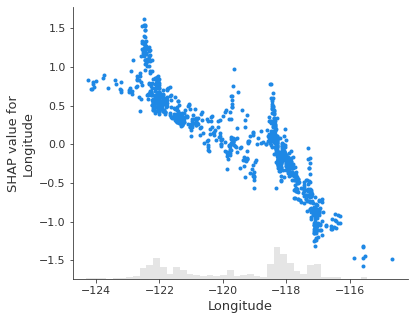

In [30]:
# Scatter plot sem interação
shap.plots.scatter(shap_values[:,"Longitude"])

Vemos uma tendência de que, com maiores valores de longitude, o valor de SHAP tende a passar de positivo para negativo.

Note que um mesmo valor de `Longitude` (eixo x) pode corresponder a diversos valores SHAP (eixo y): em geral, essa "dispersão vertical" ocorre devido ao efeito de **interação com outras variáveis**.

Em outras palavras, o valor de longitude tem um **impacto diferente** na predição do preço **para duas casas com a mesma longitude**. Isso ocorre justamente porque o modelo é não-linear, e as outras variáveis do modelo interagem com a variável `Longitude`, influenciando o impacto dessa variável na predição.
 
Já sabemos que a longitude interage significativamente com a latitude. É possível visualizar a interação com uma segunda variável *colorindo* os pontos de acordo com essa variável. Podemos escolher qualquer outra variável, mas, se não escolhermos nenhuma, o próprio SHAP escolherá a variável com a maior interação.

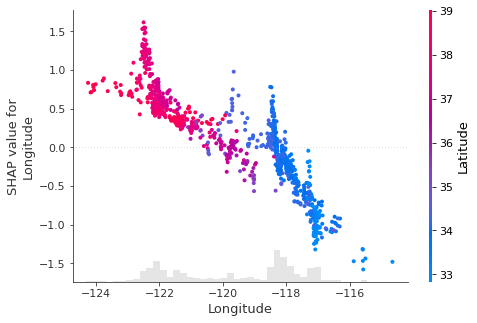

In [31]:
# Scatter plot com interação
shap.plots.scatter(shap_values[:,"Longitude"], color=shap_values)

Neste caso, conforme esperado, a variável `Latitude` foi escolhida. Vemos que valores de Latitude próximos a 38 (pontos rosa-roxo) tendem a aumentar o valor SHAP quando a longitude está perto de -122, mas não quando está mais perto de -120. Esse efeito condicional caracteriza uma interação.

### Summary plot das interações

Similar ao *Beeswarm*, mas considerando os valores de interação e não apenas os principais. Com esse plot, é possível visualizar diretamente as interações entre todas as variáveis. Plots mais "espremidos" indicam interações muito pequenas, enquanto plots mais "espalhados" mostram interações mais importantes. Os plots da diagonal são os mesmos do *Beeswarm* (portanto, correspondem aos valores principais).

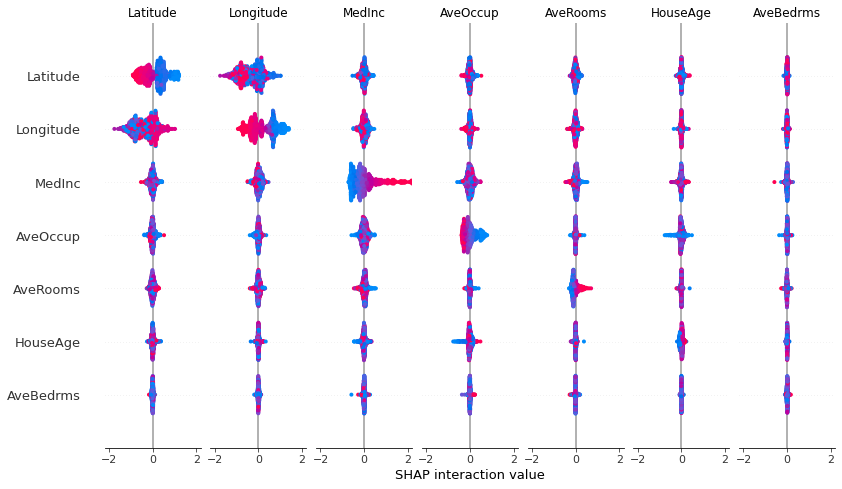

In [32]:
# Summary plot
shap.summary_plot(shap_interaction, X_test, show=False)

### Dependence plot

Podemos usar o *dependence plot* para mostrar o efeito de uma variável na resposta do modelo. O plot mostra como o valor SHAP de uma variável (eixo y) muda de acordo com o valor dessa mesma variável (eixo x). Assim como nos scatter plots, a "dispersão vertical" ocorre devido à interação com outras variáveis. Usando uma segunda variável para colorir o plot, também podemos mostrar o efeito da interação dessa variável com a original. 

O *dependence plot* requer três *inputs* obrigatórios:
- Primeiro: `ind`. É o índice (número inteiro) da variável para a qual queremos mostrar a interação. Também pode ser o nome da variável.
- Segundo: `shap_values`. É a matriz de valores SHAP
- Terceiro: `features`. Matriz dos dados (no caso, X_test)
- Opcionais: `feature_names` (nomes das variáveis, desnecessário quando passamos um DataFrame no parâmetro `features`), `interaction_index` (índice/nome da variável para colorir. Se não indicarmos uma segunda variável para colorir, o SHAP escolherá automaticamente)

Podemos escolher o índice visualmente, a partir da lista de variáveis (lembrando que o índice começa em 0):

In [33]:
X.columns # Vou escolher "HouseAge" = índice 1 e "MedInc" = índice 0

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

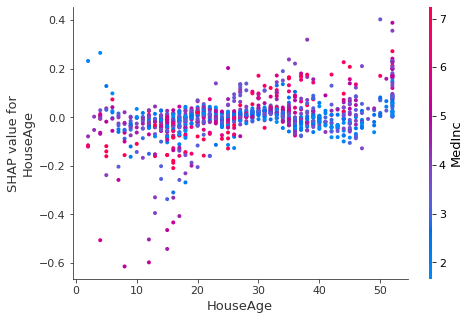

In [34]:
# Usando índices
shap.dependence_plot(
    1, 
    shap_values.values, 
    X_test, 
    interaction_index=0)

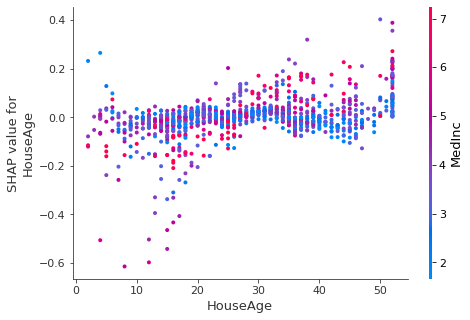

In [35]:
# Usando os nomes das variáveis
shap.dependence_plot(
    "HouseAge",
    shap_values.values, 
    X_test,
    interaction_index="MedInc")

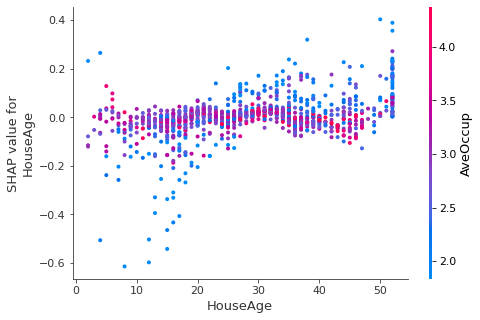

In [36]:
# Sem escolher uma variável para colorir - o shap escolheu AveOccup
shap.dependence_plot(
    "HouseAge",
    shap_values.values, 
    X_test)

[Nesse link](https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html), outras opções para *Dependence plots* são mostradas.

### Cohort bar plot

Um gráfico de barras múltiplo, com separação de classes. Pode ser interessante para ver se os valores SHAP variam de forma diferente para diferentes grupos, como uma variável binária (no exemplo abaixo, vemos como os valores SHAP variam se o valor de `HouseAge` for maior ou menor que 40 anos)

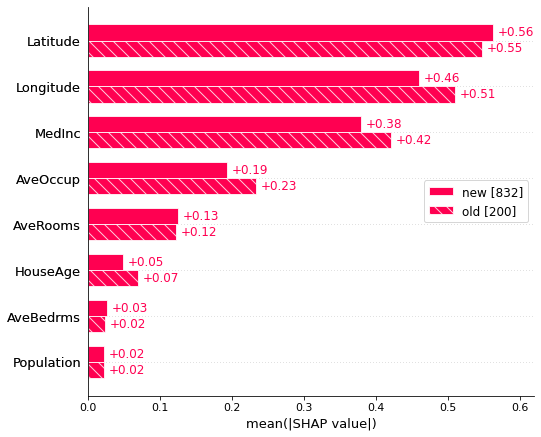

In [37]:
age = ["old" if shap_values[i,"HouseAge"].data >= 40 else "new" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(age).abs.mean(0))

Nota: Para entender melhor as interações, recomendo dar uma olhada [nesse artigo](https://towardsdatascience.com/analysing-interactions-with-shap-8c4a2bc11c2a), pois o *dataset* usado foi fabricado de forma que as interações aparecem de forma muito mais clara. A discussão também é muito boa. 

# 2. Explicando um modelo de classificação binário

Vamos usar o conjunto de dados "Adult" e treinar um modelo para classificar as instâncias em duas classes (o modelo se refere a dados do censo, o objetivo é prever se a pessoa ganha mais de $50K/ano).

Comentário: reduzi as explicações já que a ideia geral dos valores SHAP para classificação é a mesma que para regressão.

In [38]:
# Treinar modelo
X, y = shap.datasets.adult()
X.shape

(32561, 12)

In [39]:
# Verificar se todos os valores são válidos
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             32561 non-null  float32
 1   Workclass       32561 non-null  int8   
 2   Education-Num   32561 non-null  float32
 3   Marital Status  32561 non-null  int8   
 4   Occupation      32561 non-null  int8   
 5   Relationship    32561 non-null  int32  
 6   Race            32561 non-null  int8   
 7   Sex             32561 non-null  int8   
 8   Capital Gain    32561 non-null  float32
 9   Capital Loss    32561 non-null  float32
 10  Hours per week  32561 non-null  float32
 11  Country         32561 non-null  int8   
dtypes: float32(5), int32(1), int8(6)
memory usage: 954.1 KB


In [40]:
# Separar um conjunto para treinamento e um para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=0)

In [41]:
model = xgboost.XGBClassifier(use_label_encoder=False).fit(X_train, y_train)

[11:34:04] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [42]:
# Predições feitas pelo modelo
y_pred = model.predict(X_test)

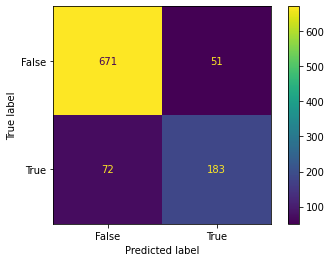

In [43]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

## 2.1. Explainer

In [44]:
# Criando um objeto "Explainer"
explainer = shap.Explainer(model)

In [45]:
# Calculando valores de Shapley
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## 2.2. Predições individuais

### Force plot

In [46]:
# Visualizar a explicação da primeira predição com um force plot
shap.plots.force(shap_values[0])

Para essa predição, vemos que o maior impacto é da variável `Relationship`, e é um impacto negativo (desloca o valor da predição para a esquerda).

Note também o valor base (*base value* em inglês) de -1.449. Apesar de se tratar de um modelo de classificação, o valor calculado é contínuo e recebe o nome de *average predicted log-odds*. O *log-odds* é uma forma de representar a probabilidade, podendo ser convertido a um valor de probabilidade (P) usando a seguinte fórmula:

log-odds = ln(P/(1–P))

A probabilidade, por sua vez, pode ser convertida em um valor binário, que é a saída do nosso modelo (em geral, P > 0.5 é classificado na classe 1, e < 0.5, na classe 0).

Para modelos de classificação, interpretamos valores SHAP positivos como valores que aumentam *log-odds*, o que por sua vez, aumenta o valor de P, e "joga a predição" para mais perto da classe 1.

### Waterfall plot

Contém as mesmas informações do *force plot*, mas é possível visualizar os valores de Shapley individualmente

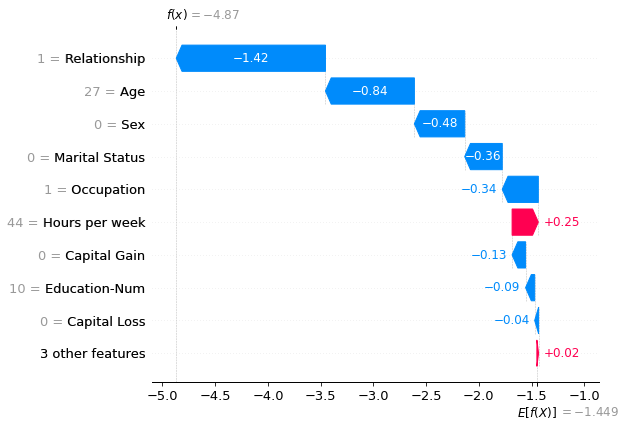

In [47]:
# visualizar as explicações da primeira predição (índice 0)
shap.plots.waterfall(shap_values[0])

Note que na explicação acima os três recursos menos impactantes foram agrupados em um único termo para limitar o gráfico a 10 linhas. O limite padrão de 10 linhas pode ser alterado usando o argumento `max_display`:

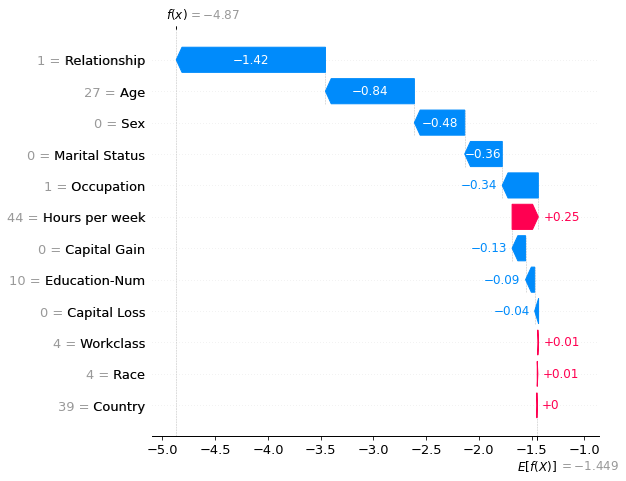

In [48]:
shap.plots.waterfall(shap_values[0], max_display=20)

### Decision plot

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


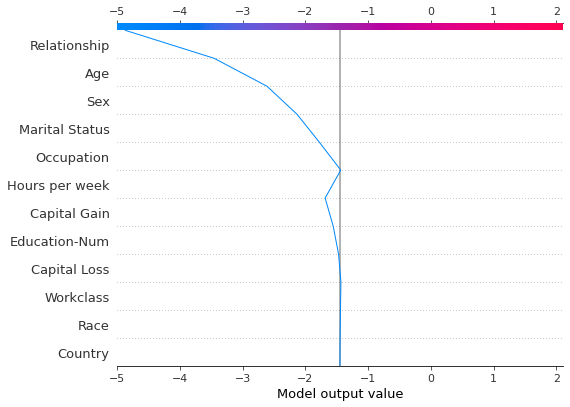

In [49]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[0], X_test.columns)

## 2.3. Predições globais

### Force plot global

In [50]:
# 100 primeiras amostras
shap.force_plot(explainer.expected_value, shap_values.values[0:100], X_test)

### Mean SHAP plots (Bar plots)

Também podemos calcular a média dos valores absolutos dos valores SHAP para cada descritor, obtendo assim um gráfico de barras. Barras maiores indicam descritores com maior impacto global.

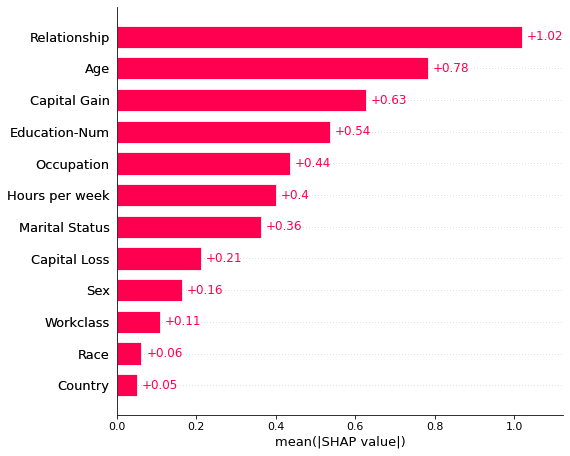

In [51]:
shap.plots.bar(shap_values, max_display=20)

Compare com a importância de variávels calculada pelo XGBoost:

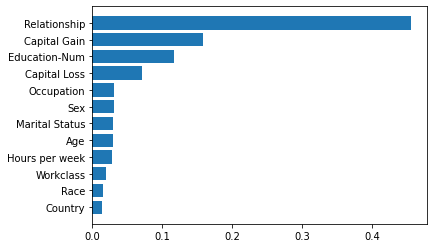

In [52]:
df_bar = pd.DataFrame()
df_bar["Features"] = model.get_booster().feature_names
df_bar["XGBoost Importance"] = model.feature_importances_
df_bar = df_bar.sort_values('XGBoost Importance')
plt.barh(df_bar["Features"], df_bar["XGBoost Importance"])
plt.show()

### Decision plot

Mostrando 100 amostras.

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


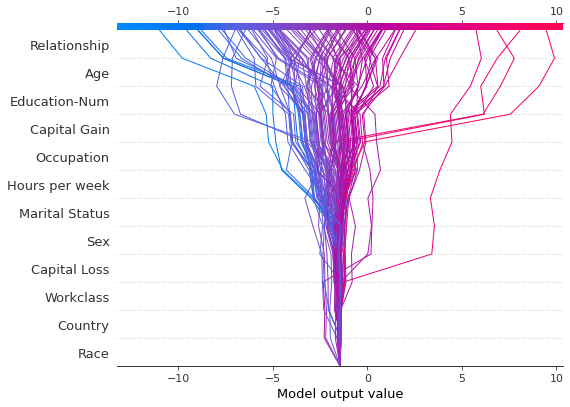

In [53]:
shap.decision_plot(explainer.expected_value, explainer.shap_values(X_test)[0:100], X_test.columns)

Note que para uma das amostras, o valor de `Capital Loss` tem um impacto positivo muito elevado. O *decision plot* é interessante para mostrar os casos "fora da curva", que muitas vezes precisam ser investigados mais de perto.

### Summary plot global (Beeswarm)

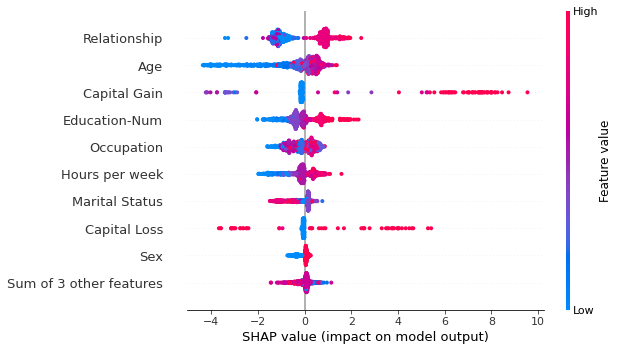

In [54]:
# Beeswarm plot
shap.plots.beeswarm(shap_values, show=False)

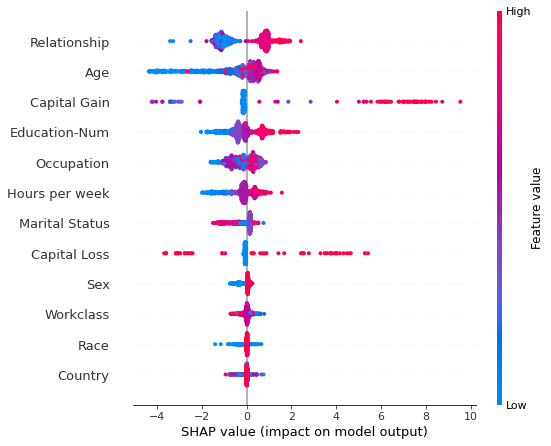

In [55]:
# # Summary plot = outra forma de mostrar o mesmo gráfico
shap.summary_plot(shap_values, X_test, show=False)

## 2.4. Interações

In [56]:
# Interações: SHAP interaction values
shap_interaction = explainer.shap_interaction_values(X_test)

### Matriz de contribuição individual

In [57]:
# SHAP interaction values para a primeira predição
pd.DataFrame(shap_interaction[0], index=X_test.columns, columns=X_test.columns)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
Age,-0.744964,-0.014517,-0.004952,-0.103117,0.015456,-0.036777,-0.007172,0.059972,-0.010234,0.004292,0.008902,-0.010333
Workclass,-0.014517,0.055613,-0.005918,-0.005912,-0.009636,-0.005767,0.003066,-0.002242,-0.000866,-0.000275,-0.006656,-0.000048
Education-Num,-0.004952,-0.005918,-0.097149,-0.003348,0.003147,0.038958,-0.000154,-0.012693,0.005273,0.004727,-0.011996,-0.002120
Marital Status,-0.103117,-0.005912,-0.003348,0.000699,-0.099791,-0.175789,-0.002654,0.033168,0.003223,0.000635,0.000539,-0.003704
Occupation,0.015456,-0.009636,0.003147,-0.099791,-0.104556,-0.049756,-0.004276,-0.072856,-0.001431,0.000582,-0.019054,0.000218
Relationship,-0.036778,-0.005767,0.038958,-0.175789,-0.049756,-1.034549,-0.002808,-0.201261,0.017027,0.008788,0.026316,0.000392
Race,-0.007172,0.003066,-0.000154,-0.002654,-0.004276,-0.002808,0.019093,-0.001620,-0.000110,0.000047,0.003619,-0.001281
Sex,0.059972,-0.002242,-0.012693,0.033168,-0.072856,-0.201261,-0.001620,-0.239397,-0.003535,0.000010,-0.037834,0.000900
Capital Gain,-0.010234,-0.000866,0.005273,0.003223,-0.001431,0.017027,-0.000110,-0.003535,-0.135542,-0.000668,-0.000877,-0.000020
Capital Loss,0.004292,-0.000275,0.004727,0.000635,0.000581,0.008787,0.000047,0.000010,-0.000668,-0.056119,0.000960,-0.000096


In [58]:
# Valor médio das predições
mean_pred = np.mean(y_pred)

# Soma dos interaction values para a primeira predição
sum_shap = np.sum(shap_interaction[0])

print("Predição (primeira amostra): {:.3f}".format(y_pred[0]))
print("Valor médio das predições: {:.3f}".format(mean_pred))
print("Interaction values (primeira amostra): {:.3f}".format(sum_shap))
print("Valor médio das predições + interaction values: {:.3f}".format(mean_pred + sum_shap))

Predição (primeira amostra): 0.000
Valor médio das predições: 0.240
Interaction values (primeira amostra): -3.421
Valor médio das predições + interaction values: -3.181


Note como a predição é um valor contínuo (-3.181), que convertida a probabilidade dá 0,04, ou seja, mais próximo de 0 do que de 1 (de fato, a predição para essa amostra é 0).

Veja também que o valor base é de 0.240, que dá 0.56 em probabilidade, próximo ao valor central de 0.5. Se os dados estivessem desbalanceados, esse valor base oscilaria na direção da classe predominante.

### Média absoluta

In [59]:
# Valores absolutos médios de todas as matrizes
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X_test.columns, columns=X_test.columns)

# Multiplicando os valores fora das diagonais por 2
df.where(df.values == np.diagonal(df), df.values*2, inplace=True)

# Usando o colormap para destacar os valores maiores
df.style.background_gradient(cmap='Blues', axis=None)

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
Age,0.767117,0.060683,0.113568,0.092023,0.162228,0.132368,0.031911,0.039880,0.066894,0.024569,0.116100,0.030406
Workclass,0.060683,0.101731,0.053091,0.019583,0.062064,0.029396,0.020275,0.011134,0.017278,0.009155,0.042833,0.011170
Education-Num,0.113568,0.053091,0.520658,0.073630,0.076991,0.130643,0.017657,0.027658,0.034687,0.027536,0.053327,0.021269
Marital Status,0.092023,0.019583,0.073630,0.266989,0.046286,0.257446,0.020358,0.048300,0.019894,0.010638,0.076960,0.009649
Occupation,0.162229,0.062064,0.076991,0.046286,0.398412,0.062049,0.021955,0.043922,0.013098,0.008288,0.095007,0.028848
Relationship,0.132368,0.029396,0.130643,0.257446,0.062049,1.056398,0.019007,0.110455,0.082165,0.084491,0.135556,0.011761
Race,0.031911,0.020275,0.017657,0.020358,0.021955,0.019007,0.050818,0.009495,0.002733,0.003578,0.023268,0.014797
Sex,0.039880,0.011134,0.027658,0.048300,0.043922,0.110455,0.009495,0.141533,0.004805,0.000853,0.022063,0.005848
Capital Gain,0.066894,0.017278,0.034687,0.019894,0.013098,0.082165,0.002733,0.004805,0.622592,0.009154,0.025126,0.000266
Capital Loss,0.024569,0.009155,0.027536,0.010638,0.008288,0.084491,0.003578,0.000853,0.009154,0.203580,0.009300,0.000585


### Scatter plot sem/com interação

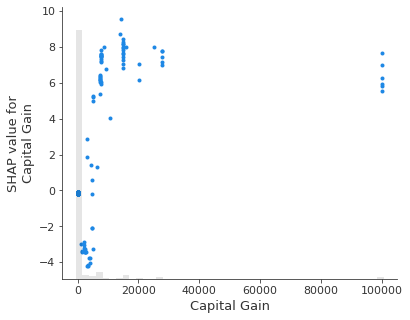

In [60]:
# Scatter plot sem interação
shap.plots.scatter(shap_values[:,"Capital Gain"])

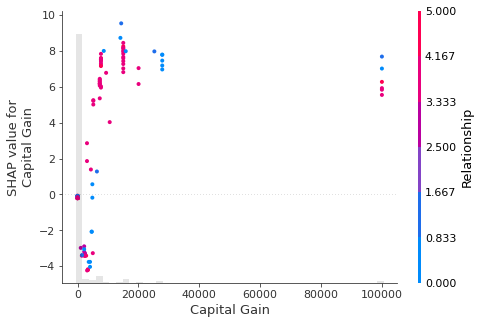

In [61]:
# Scatter plot com interação
shap.plots.scatter(shap_values[:,"Capital Gain"], color=shap_values)

### Summary plot das interações

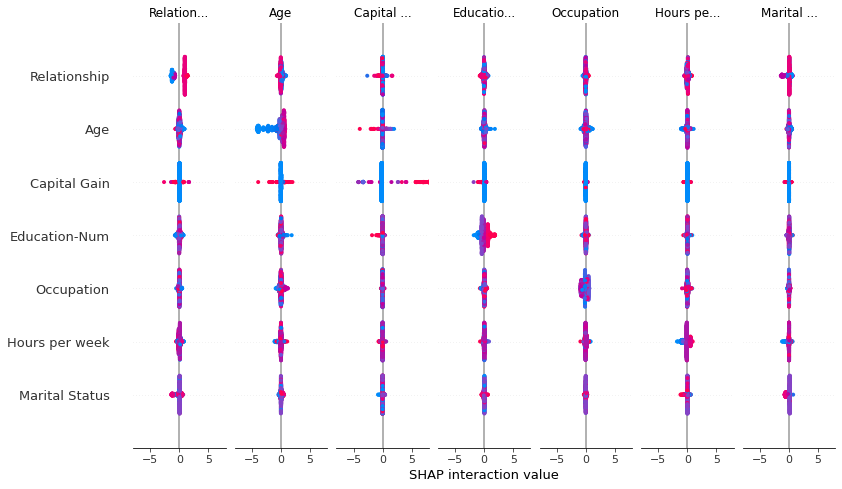

In [62]:
# Summary plot
shap.summary_plot(shap_interaction, X_test)

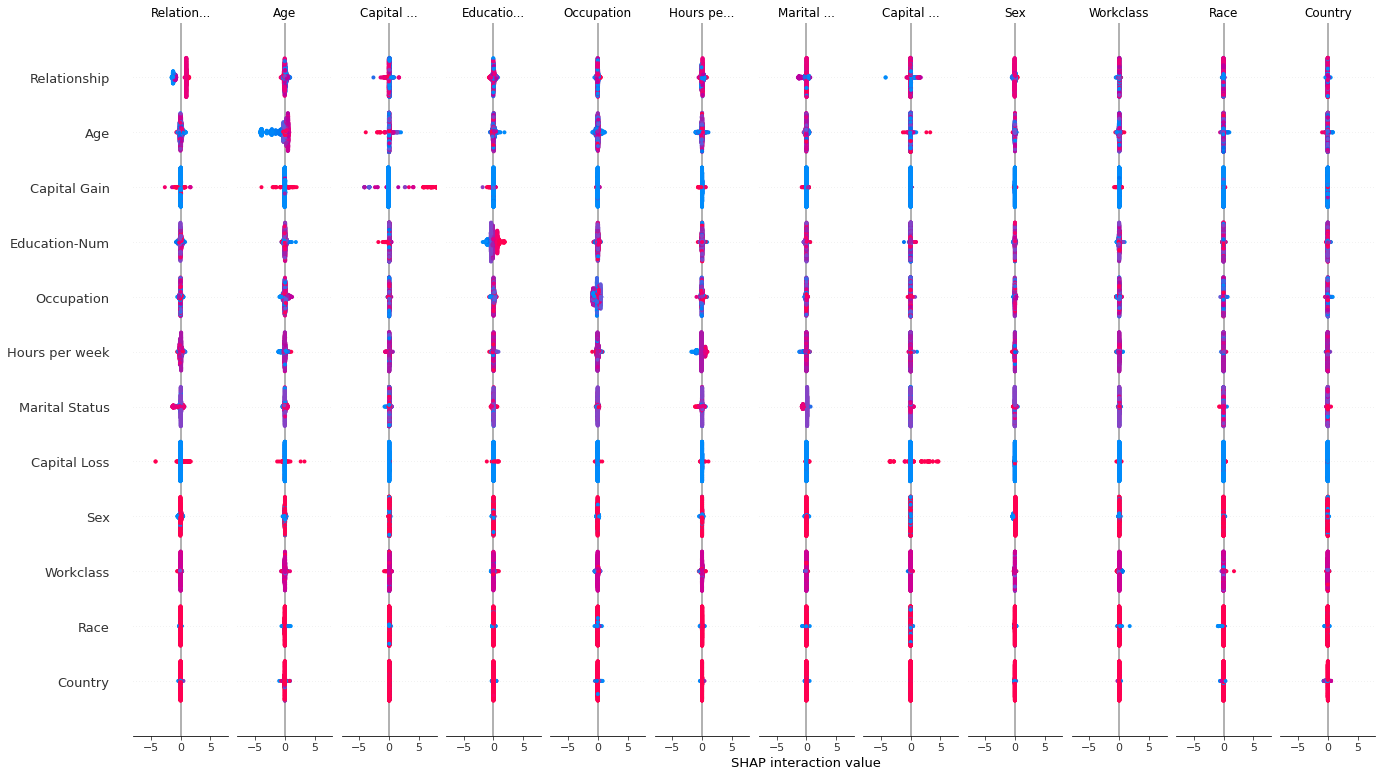

In [63]:
# Mostrando todas as variáveis - pouco informativo, plots muito pequenos
shap.summary_plot(shap_interaction, X_test, max_display=20)

### Dependence plot

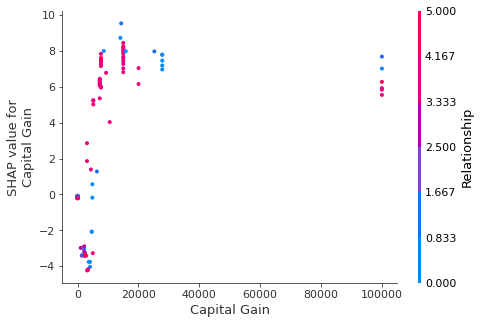

In [64]:
# Usando os nomes das variáveis
shap.dependence_plot(
    "Capital Gain",
    shap_values.values, 
    X_test,
    interaction_index="Relationship")

### Cohort bar plot

Vejamos como os valores SHAP variam se o valor de `Sex` for 0 ou 1:

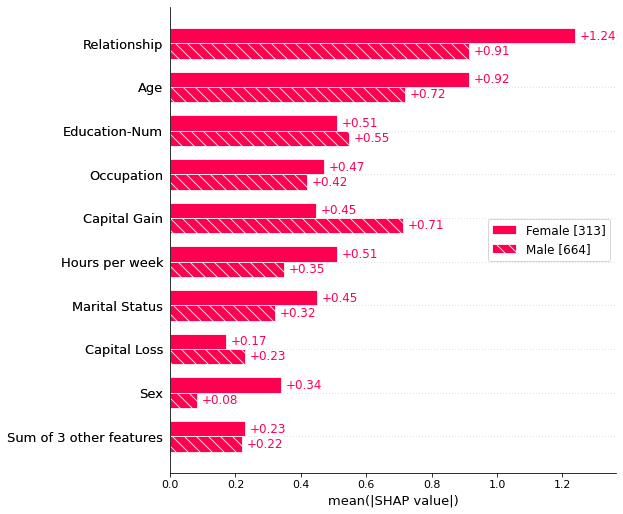

In [65]:
sex = ["Male" if shap_values[i,"Sex"].data == 1 else "Female" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

# 3. Explicando um modelo de classificação multiclasse

Vamos usar o conjunto de dados "Iris" e treinar um modelo para classificar as flores em uma de três classes disponíveis.

De forma geral, as explicações disponíveis são parecidas com as do modelo binário, mas em muitos casos temos que criar visualizações separadas para cada uma das classes.

Não consegui reproduzir todas as visualizações.

In [66]:
X, y = shap.datasets.iris()

In [67]:
# Verificar se todos os valores são válidos
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [68]:
# Separar um conjunto para treinamento e um para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [69]:
model = xgboost.XGBClassifier(use_label_encoder=False).fit(X_train, y_train)

[11:34:35] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [70]:
# Predições feitas pelo modelo
y_pred = model.predict(X_test)

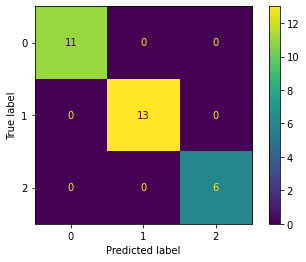

In [71]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
disp.plot()
plt.show()

## 3.1. Explainer

In [72]:
# compute SHAP values
explainer = shap.TreeExplainer(model)

In [73]:
shap_values = explainer.shap_values(X_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


## 3.2. Predições individuais

### Force plot

Como vimos anteriormente, os valores preditos em um modelo de classificação são log-odds, que são posteriormente convertidos aos valores da classe, sendo a classe predita correspondente ao maior valor de log-odds.

No código abaixo, eu comparo os valores preditos pelo modelo (`y_pred[i]`) com o índice correspondente ao maior valor da lista que contém as predições feitas pelo SHAP (uma lista de 3 valores, um para cada classe). Veja que o *loop* não quebra, ou seja, conforme esperado, o maior valor entre os três log-odds calculados (um para cada classe) corresponde à predição final do modelo.

In [74]:
for i in range(len(y_pred)):
    s = np.argmax([explainer.expected_value[0] + shap_values[0][i].sum(), 
                   explainer.expected_value[1] + shap_values[1][i].sum(), 
                   explainer.expected_value[2] + shap_values[2][i].sum()])
    if y_pred[i] != s:
        print(i)
        break

Vamos ver abaixo três exemplos de amostras que foram classificadas em cada uma das três classes. Valores que desviam a predição para a direita aumentam o log-odds e, consequentemente, a probabilidade de que a amostra pertence a essa classe. 

In [75]:
amostra = 15
print(f"Índice da amostra: {amostra}")
print(f"Valor da predição: {y_pred[amostra]}")

Índice da amostra: 15
Valor da predição: 0


In [76]:
shap.force_plot(explainer.expected_value[y_pred[amostra]], 
                shap_values[y_pred[amostra]][amostra], 
                feature_names=X.columns)

In [77]:
amostra = 27
print(f"Índice da amostra: {amostra}")
print(f"Valor da predição: {y_pred[amostra]}")

Índice da amostra: 27
Valor da predição: 1


In [78]:
shap.force_plot(explainer.expected_value[y_pred[amostra]], 
                shap_values[y_pred[amostra]][amostra], 
                feature_names=X.columns)

In [79]:
amostra = 0
print(f"Índice da amostra: {amostra}")
print(f"Valor da predição: {y_pred[amostra]}")

Índice da amostra: 0
Valor da predição: 2


In [80]:
shap.force_plot(explainer.expected_value[y_pred[amostra]], 
                shap_values[y_pred[amostra]][amostra], 
                feature_names=X.columns)

Mostramos somente os force plots correspondentes às classes preditas para cada amostra. Por exemplo, a amostra 15 foi predita como pertencente à classe 0. É possível mostrar os force plots para todas as classes (no caso, para as classes 1 e 2), nesse caso, temos que observar os valores que diminuem os log-odds para aquela classe.

Em outras palavras, é como se o modelo dissesse: não coloquei a amostra nessa classe porque esse descritor diminuiu os log-odds para essa classe. Vamos ver abaixo como isso funciona, usando a amostra 15 como exemplo:

In [81]:
# Valores de probabilidades para todas as amostras
y_pred_proba = model.predict_proba(X_test)

# Log-odds para a amostra 15
log_odds_15 = [p/(1-p) for p in y_pred_proba[15]]
log_odds_15

[257.50872110939906, 0.0029846322360495467, 0.0008934179586601737]

In [82]:
# Force plot para a classe 0
shap.force_plot(explainer.expected_value[0], 
                shap_values[0][15], 
                feature_names=X.columns)

In [83]:
# Force plot para a classe 1
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][15], 
                feature_names=X.columns)

In [84]:
# Force plot para a classe 2
shap.force_plot(explainer.expected_value[2], 
                shap_values[2][15], 
                feature_names=X.columns)

De fato, o maior valor de log-odds foi para a classe 0, e a amostra é colocada nessa classe.

### Waterfall plot

Mostrando os Waterfall plots para a amostra 8 (um plot para cada classe)

In [85]:
row = 8

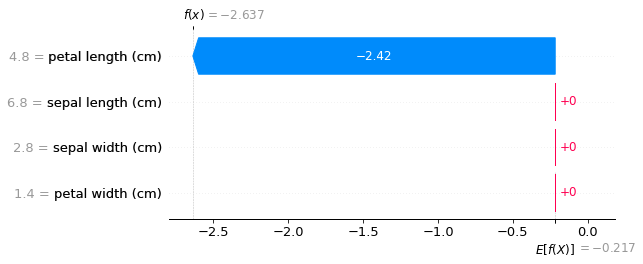

In [86]:
# Classe 0
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                     base_values=explainer.expected_value[0], 
                                     data=X_test.iloc[row],  
                                     feature_names=X_test.columns.tolist()))

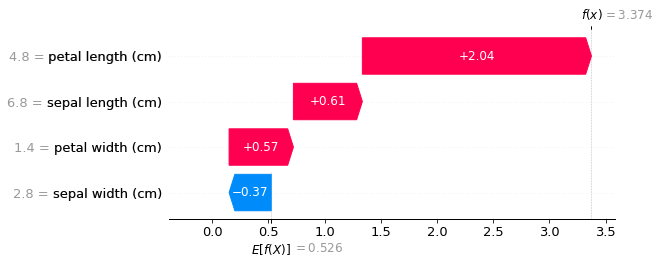

In [87]:
# Classe 1
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                     base_values=explainer.expected_value[1], 
                                     data=X_test.iloc[row],  
                                     feature_names=X_test.columns.tolist()))

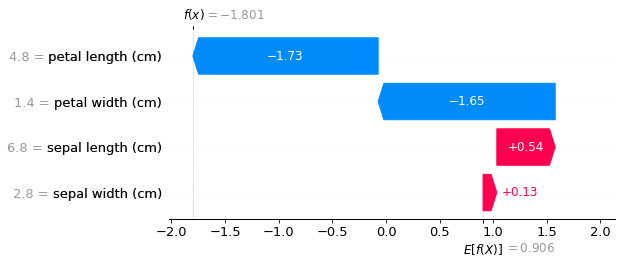

In [88]:
# Classe 2
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                     base_values=explainer.expected_value[2], 
                                     data=X_test.iloc[row],  
                                     feature_names=X_test.columns.tolist()))

Vemos que o maior valor de log-odds é o da classe 1 (3.374). Essa deve ser a predição do modelo para essa amostra:

In [89]:
print(f"Classe predita para a amostra 8: {y_pred[8]}")

Classe predita para a amostra 8: 1


### Decision plot

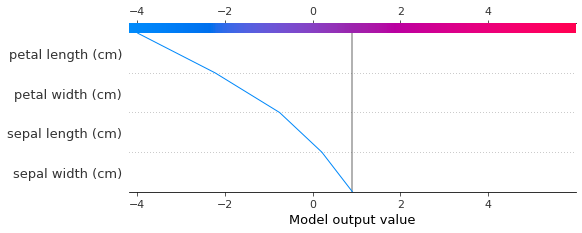

In [90]:
# Decision plot: amostra 15, classe 2
shap.decision_plot(explainer.expected_value[2], 
                   shap_values[2][15], 
                   feature_names=X_test.columns.tolist())

Também podemos fazer um *decision plot* para uma amostra considerando todas as classes. No exemplo abaixo, fiz para a amostra 21.

In [91]:
# Código para fazer a legenda do plot
class_count = len(explainer.expected_value)

def class_labels(row_index):
    return [f'Classe {i} ({(explainer.expected_value[i] + shap_values[i][row_index].sum()).round(2):.2f})' for i in range(class_count)]
    # return [f'Class {i + 1} ({y_pred_proba[row_index][i].round(2):.2f})' for i in range(class_count)]

In [92]:
print(f"Classe predita para a amostra 21: {y_pred[21]}")

Classe predita para a amostra 21: 1


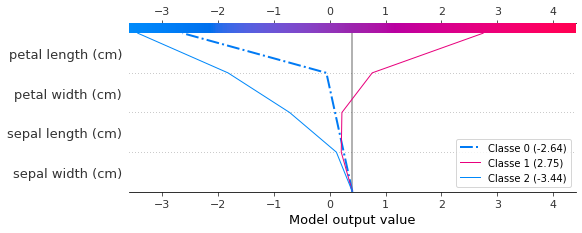

In [93]:
# Decision plot multiclasse
row_index = 21  # índice da amostra
shap.multioutput_decision_plot(explainer.expected_value, 
                               shap_values,
                               row_index=row_index,
                               feature_names=X.columns.to_list(),
                               highlight=[np.argmax(y_pred[row_index])],
                               legend_labels=class_labels(row_index),
                               legend_location='lower right')

## 3.3. Predições globais

### Force plot global

O Force plot global mostra as influências das variáveis em todas as predições. Da mesma forma que antes, azul indica valor SHAP negativo, e rosa, positivo. Como temos três classes, precisamos fazer três plots, mostrando como cada variável impacta os log-odds para as amostras (eixo x). Acho esse plot confuso.

In [94]:
# Force plot global para a classe 0
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [95]:
# Force plot global para a classe 1
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

In [96]:
# Force plot global para a classe 2
shap.force_plot(explainer.expected_value[2], shap_values[2], X_test)

### Mean SHAP plots (Bar plots)

Devemos criar um gráfico de barras para cada classe.

In [97]:
shap_obj = explainer(X_train)

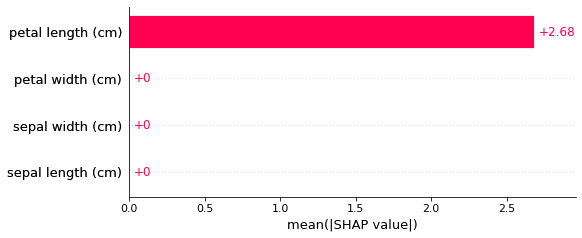

In [98]:
shap.plots.bar(shap_obj[:, :, 0])

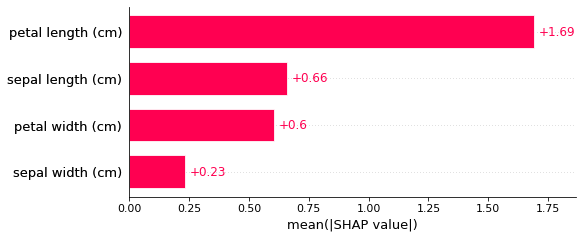

In [99]:
shap.plots.bar(shap_obj[:, :, 1])

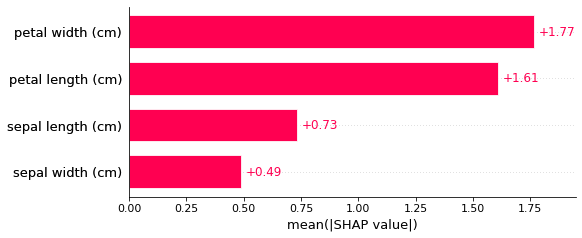

In [100]:
shap.plots.bar(shap_obj[:, :, 2])

### Decision plot

Não procurei saber como fazer o plot global multiclasse porque o *decision plot*, que já é confuso com modelos binários, deve ficar pior com várias classes.

Acredito que repetir o código mostrado em 3.2 usando `show=False` pode funcionar.

### Summary plot global (Beeswarm)

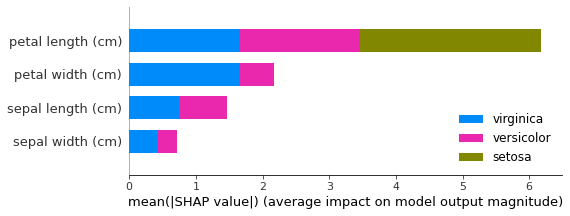

In [101]:
shap.summary_plot(shap_values=shap_values, 
                  features=X_test, 
                  feature_names=X_test.columns.tolist(),  
                  plot_type='bar', 
                  class_names=['setosa', 'versicolor', 'virginica'])

Vemos que o modelo só usa a variável `petal length` para classificar a classe "setosa". Já a variável `petal width` é mais importante para explicar "virginica" do que "versicolor".

Também podemos fazer os plots Beewsarm, porém, precisamos fazer um plot para cada classe.

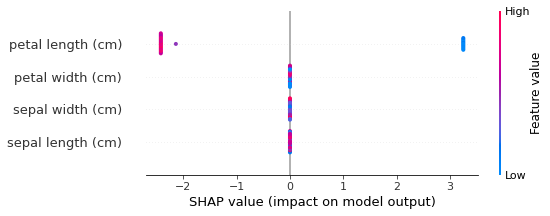

In [102]:
# summary plot da classe 0 - setosa
shap.summary_plot(shap_values[0], X_test)
# Confirmamos que somente a variável petal length é importante para essa classe

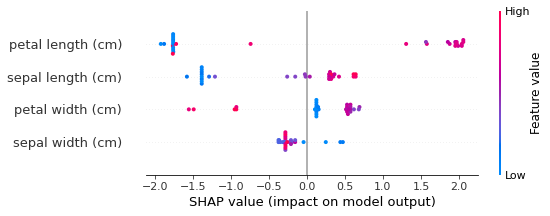

In [103]:
# summary plot da classe 1 - versicolor
shap.summary_plot(shap_values[1], X_test)

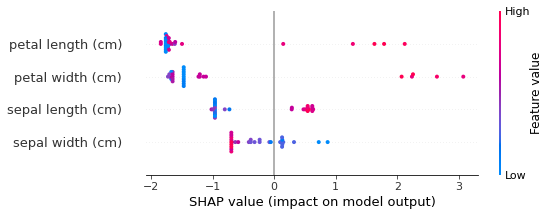

In [104]:
# summary plot da classe 2 - virginica
shap.summary_plot(shap_values[2], X_test)

## 3.4. Interações

Não consegui gerar a maior parte dos plots. Pretendo atualizar essa parte conforme o `shap` for modificado para facilitar a produção desses plots.

### Dependence plot

*Dependence plot* para a variável de índice 0 (`sepal length (cm)`) e para a classe 2, colorido automaticamente com a variável `petal width (cm)`

In [105]:
# Variáveis correspondentes a cada índice
X_test.columns.to_list()

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

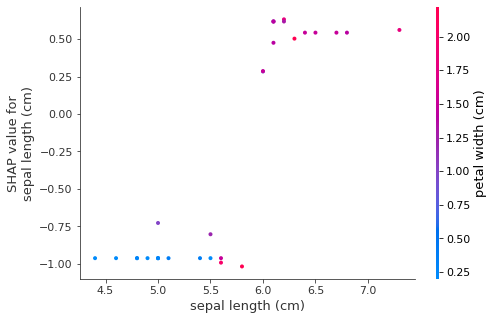

In [106]:
# Passando o índice da variável
shap.dependence_plot(0, 
                     shap_values[2], 
                     X_test.values, 
                     feature_names=X_test.columns)

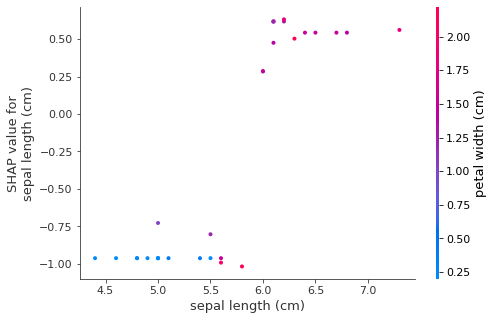

In [107]:
# Passando o nome da variável
shap.dependence_plot('sepal length (cm)', 
                     shap_values[2], 
                     X_test.values, 
                     feature_names=X_test.columns)

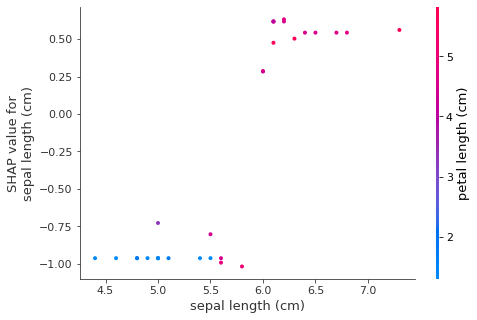

In [108]:
# Podemos colorir usando outra variável
shap.dependence_plot('sepal length (cm)', 
                     shap_values[2], 
                     X_test.values, 
                     feature_names=X_test.columns,
                     interaction_index="petal length (cm)")

# 4. Usando KernelExplainer

Esse é um `Explainer` genérico que funciona para todos os tipos de modelos. É um pouco mais chato de usar, mais lento e não tem todas as funcionalidades do `TreeExplainer` (por exemplo, plots de interação). 

Recomendações gerais: Quando possível, opte por usar o `shap` com modelos baseados em árvores, para poder usar o `TreeExplainer`. Para modelos de deep learning, é possível usar o `DeepExplainer` (não será abordado neste Notebook).

In [109]:
from sklearn.neighbors import KNeighborsClassifier

In [110]:
X, y = shap.datasets.adult()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.03, random_state=0)

In [111]:
X_train.shape

(31584, 12)

In [112]:
# O autor recomenda normalizar os dados
# dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

# for k,dtype in dtypes:
for k in list(X_train.columns):
    m = X_train[k].mean()
    s = X_train[k].std()
    X_train_norm[k] -= m
    X_train_norm[k] /= s

    X_test_norm[k] -= m
    X_test_norm[k] /= s

## 4.1 Explainer a partir de um modelo k-nearest neighbors

In [113]:
# Modelo KNN
knn_norm = KNeighborsClassifier()
knn_norm.fit(X_train_norm, y_train)

KNeighborsClassifier()

In [114]:
# Predições feitas pelo modelo
y_pred = knn_norm.predict(X_test_norm)

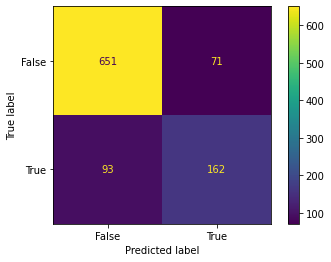

In [115]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=knn_norm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=knn_norm.classes_)
disp.plot()
plt.show()

Antes de usar o `KernelExplainer`, é necessário uma preparação, pois ele não recebe o modelo diretamente como input:

In [116]:
f = lambda x: knn_norm.predict_proba(x)[:,1]
med = X_train_norm.median().values.reshape((1,X_train_norm.shape[1]))

In [117]:
# Criando o objeto Explainer usando o KernelExplainer
explainer = shap.KernelExplainer(f, med)

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [118]:
type(explainer)

shap.explainers._kernel.Kernel

Em seguida, calculamos os valores SHAP. Note o uso do argumento `nsamples=1000`: o valor padrão é 2048 + 2 * (número total de variáveis). Como o `KernelExplainer` é mais demorado, o autor optou por usar somente 1000 - isso faz com que os valores SHAP sejam menos estáveis. [Veja mais aqui](https://shap-lrjball.readthedocs.io/en/docs_update/generated/shap.KernelExplainer.html#shap.KernelExplainer.shap_values)

In [119]:
%%capture
# o comando %%capture suprime o output na forma de texto
shap_values_norm = explainer.shap_values(X_test_norm.iloc[0:,:], nsamples=1000)

## 4.2 Predições individuais

### Force plots - individual e para várias amostras

Exemplo de predição = 0

In [120]:
print(f"Predição para a amostra 0 = {int(knn_norm.predict(np.array(X_test_norm.iloc[0,:]).reshape(1, -1))[0])}")

Predição para a amostra 0 = 0


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [121]:
# Exemplo de predição = 0
shap.force_plot(explainer.expected_value, shap_values_norm[0], X_test_norm.iloc[0,:])

Exemplo de predição = 1

In [122]:
print(f"Predição para a amostra 900 = {int(knn_norm.predict(np.array(X_test_norm.iloc[900,:]).reshape(1, -1))[0])}")

Predição para a amostra 900 = 1


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


In [123]:
# Exemplo de predição = 1
shap.force_plot(explainer.expected_value, shap_values_norm[900], X_test_norm.iloc[900,:])

### Waterfall plot

Mostrando o Waterfall plot para a amostra 8.

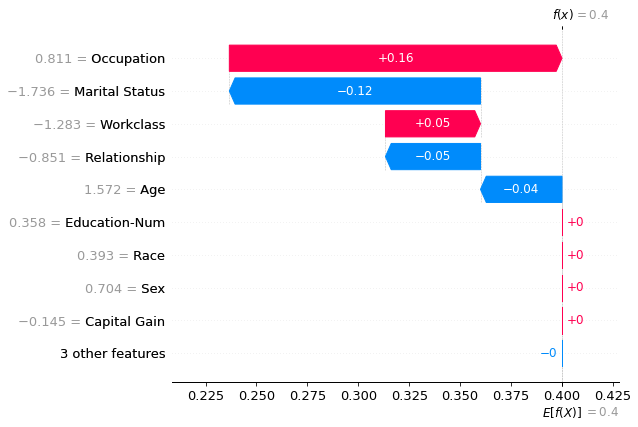

In [124]:
row = 8
shap.waterfall_plot(shap.Explanation(values=shap_values_norm[row], 
                                     base_values=explainer.expected_value, 
                                     data=X_test_norm.iloc[row],  
                                     feature_names=X_test.columns.tolist()))

In [125]:
print(f"Predição para a amostra 8 = {int(knn_norm.predict(np.array(X_test_norm.iloc[900,:]).reshape(1, -1))[0])}")

Predição para a amostra 8 = 1


X does not have valid feature names, but KNeighborsClassifier was fitted with feature names


### Decision plot

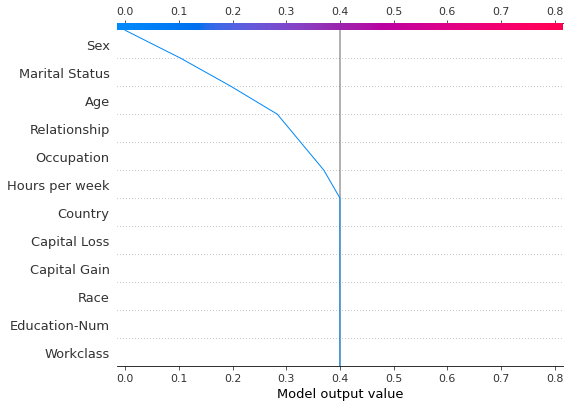

In [126]:
shap.decision_plot(explainer.expected_value, 
                   shap_values_norm[0], 
                   feature_names=X_test.columns.to_list())

## 4.3 Predições globais

### Force plot global

Force plot para todas as amostras (cada valor no eixo x corresponde a uma barrinha como a mostrada acima)

In [127]:
shap.force_plot(explainer.expected_value, shap_values_norm, X_test_norm.iloc[0:,:])

### Mean SHAP plots (Bar plots)

A função `shap.plots.bar` não funciona, mas é possível criar o bar plot do zero, se necessário.

### Summary plot global (Beeswarm)

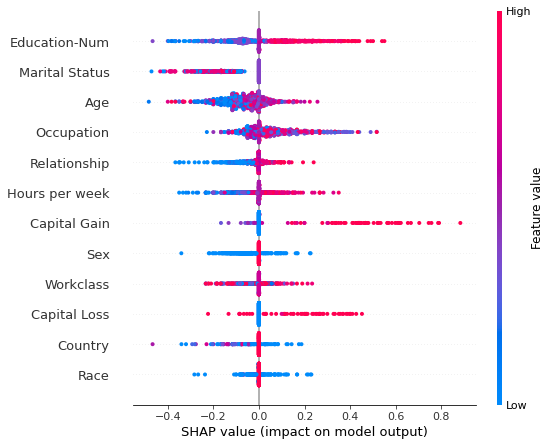

In [128]:
shap.summary_plot(shap_values_norm, X_test_norm.iloc[0:,:])

## 4.4 Interações

Aparentemente, os `shap_interaction_values` ainda não estão disponíveis para o KernelExplainer: https://github.com/slundberg/shap/issues/2579

### Dependence plot

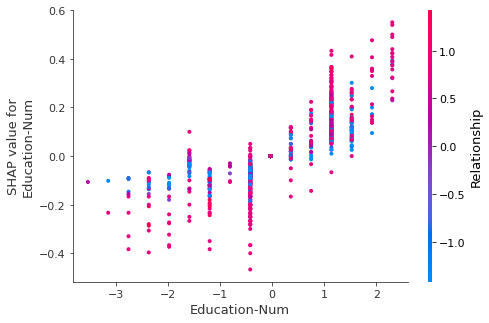

In [129]:
shap.dependence_plot("Education-Num", shap_values_norm, X_test_norm.iloc[0:,:])